# 

## Importing the libraries and the dataset

In [54]:
import pandas as pd
import numpy as np
import math
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score 

df = pd.read_csv("Weather Dataset/clean_weather.csv", index_col=0)
df = df.ffill()

In [55]:
print(df.shape)
np.array(df.head())

(13509, 4)


array([[60., 35.,  0., 52.],
       [52., 39.,  0., 52.],
       [52., 35.,  0., 53.],
       [53., 36.,  0., 52.],
       [52., 35.,  0., 50.]])

## Exploratory Data Analysis 

,tmax,tmin,rain
count,13509.000000,13509.000000,13509.000000
mean,66.057073,50.428677,0.045804
std,8.328977,6.792531,0.180576
min,38.000000,1.000000,0.000000
25%,60.000000,46.000000,0.000000
50%,66.000000,51.000000,0.000000
75%,71.000000,56.000000,0.000000
max,122.000000,69.000000,3.580000


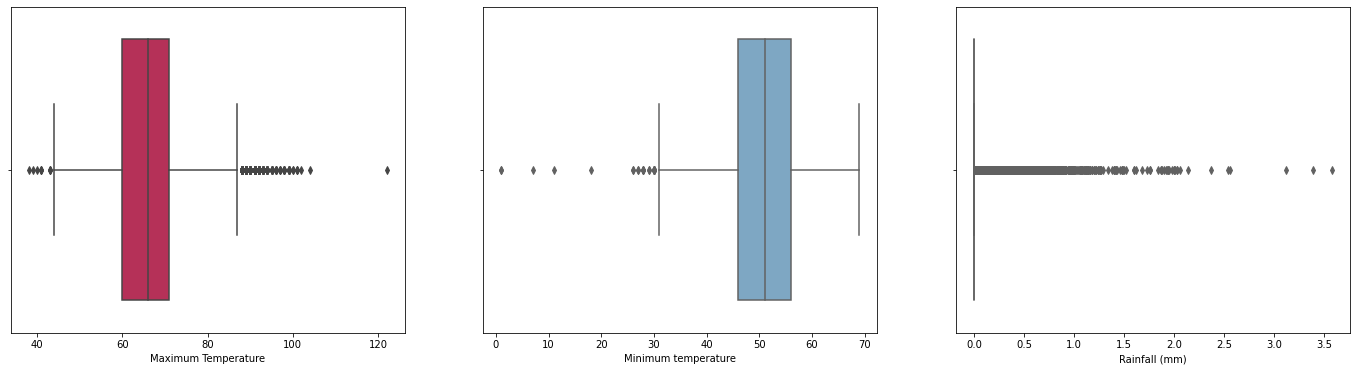

In [56]:
fig, axs = plt.subplots(1,3,figsize=(24,6))

sns.boxplot(data=df, x = "tmax", ax=axs[0], palette = "rocket")
axs[0].set_xlabel("Maximum Temperature")

sns.boxplot(data=df, x = "tmin", ax=axs[1], palette = "PuBu")
axs[1].set_xlabel("Minimum temperature")

sns.boxplot(data=df, x = "rain", ax=axs[2], palette = "PuBu")
axs[2].set_xlabel("Rainfall (mm)")

df[["tmax", "tmin", "rain"]].describe()

Text(0, 0.5, 'Maximum Temperature Tomorrow')

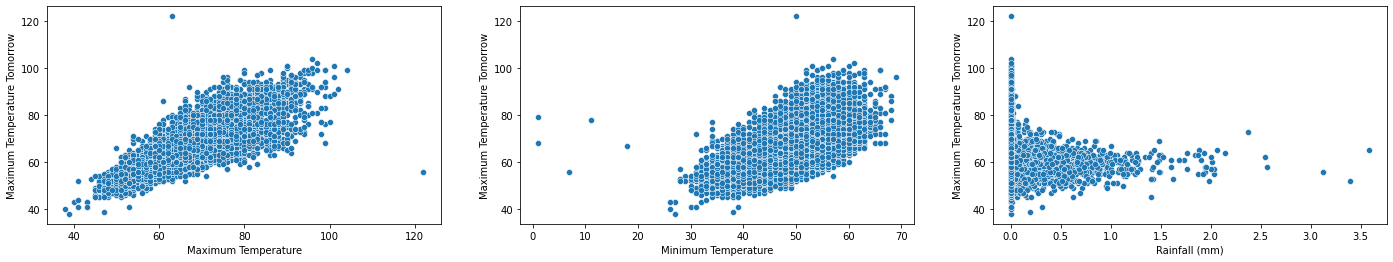

In [57]:
fig, axs = plt.subplots(1,3,figsize=(24,4))

sns.scatterplot(data=df, x="tmax", y="tmax_tomorrow", palette="blue", ax=axs[0])
axs[0].set_xlabel("Maximum Temperature")
axs[0].set_ylabel("Maximum Temperature Tomorrow")

sns.scatterplot(data=df, x="tmin", y="tmax_tomorrow", ax=axs[1])
axs[1].set_xlabel("Minimum Temperature")
axs[1].set_ylabel("Maximum Temperature Tomorrow")

sns.scatterplot(data=df, x="rain", y="tmax_tomorrow", palette="blue", ax=axs[2])
axs[2].set_xlabel("Rainfall (mm)")
axs[2].set_ylabel("Maximum Temperature Tomorrow")

## Data Scaling

In [58]:
scaler = StandardScaler()
df[["tmax", "tmin", "rain"]] = scaler.fit_transform(df[["tmax", "tmin", "rain"]])

split_data = np.split(df, [int(.7*len(df)), int(.85*len(df))])

train_x = split_data[0][["tmax", "tmin", "rain"]]
train_y = split_data[0][["tmax_tomorrow"]]
valid_x = split_data[1][["tmax", "tmin", "rain"]]
valid_y = split_data[1][["tmax_tomorrow"]]
test_x = split_data[2][["tmax", "tmin", "rain"]]
test_y = split_data[2][["tmax_tomorrow"]]

## Building the Recurrent Neural Network from scratch 

In [90]:
#np.random.seed(0)
class RNN():
    
    def __init__(self, lr, input_size, sequence_length, hidden_size, output_size):
        self.lr = lr
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.output_size = output_size
    
    def init_parameters(self, input_size, hidden_size, output_size):
        #All matrix dimensions are shown assuming a sequence length & hidden size of 5 input size of 3 and output size of 1
        i_weight = np.random.rand(input_size, hidden_size)
        h_weight = np.random.rand(hidden_size, hidden_size)
        h_bias = np.random.rand(1, hidden_size)
        o_weight = np.random.rand(hidden_size, output_size)
        o_bias = np.random.rand(1, output_size)
        
        parameters = {"i_weight":i_weight, "h_weight": h_weight, "h_bias":h_bias, "o_weight": o_weight, "o_bias":o_bias}
        return parameters
    
    def forward(self, x, parameters):
            hiddens = np.zeros((self.sequence_length, self.hidden_size))
            outputs = np.zeros((self.sequence_length, self.output_size))
            h_prev = np.zeros((1, self.hidden_size))
            for j in range(self.sequence_length):
                xi = x[j,:][np.newaxis,:] @ parameters["i_weight"] #1x5
                hi = np.tanh(xi + h_prev @ parameters["h_weight"] + parameters["h_bias"]) #1x5
                h_prev = hi
                oi = hi @ parameters["o_weight"] + parameters["o_bias"]
                hiddens[j,:] = hi #5x5
                outputs[j,:] = oi #5x1
            return hiddens, outputs
        
    def backward(self, x, y, hiddens, outputs, parameters):
        next_hidden_grad = None
        loss_grad =  (outputs - y)
        o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0]*5
        for j in range(self.sequence_length-1, -1, -1):
            #print(hiddens[j,:][:,np.newaxis].shape, loss_grad[:,j][:,np.newaxis].shape)
            o_weight_grad += hiddens[j,:][:,np.newaxis] @ loss_grad[j,:][np.newaxis, :] #5x1
            o_bias_grad += loss_grad[j,:][np.newaxis, :] #1x1
            hidden_grad =  loss_grad[j,:][np.newaxis, :] @ parameters["o_weight"].T  #1x5
            
            if next_hidden_grad is not None:
                hidden_grad = hidden_grad + next_hidden_grad @ parameters["h_weight"].T #1x5 Why T?
            
            tanh_derivative = 1 - hiddens[j][np.newaxis,:]**2 #1x5
            hidden_grad = np.multiply(hidden_grad, tanh_derivative) #1x5
            next_hidden_grad = hidden_grad.copy() #1x5
            
            if j>0:
                h_weight_grad += hiddens[j-1][:,np.newaxis] @ hidden_grad #5x5
                h_bias_grad += hidden_grad #1x5
            
            i_weight_grad += x[j,:][:,np.newaxis] @ hidden_grad
            
        lr = self.lr/self.sequence_length
        o_weight = parameters["o_weight"] -  o_weight_grad * lr
        o_bias = parameters["o_bias"] - o_bias_grad * lr
        h_weight = parameters["h_weight"] - h_weight_grad * lr
        h_bias = parameters["h_bias"] - h_bias_grad * lr
        i_weight = parameters["i_weight"] - i_weight_grad * lr
        
        return o_weight, o_bias, h_weight, h_bias, i_weight
    
    def train(self, X, Y, XV, YV, epochs):
        parameters = self.init_parameters(self.input_size, self.hidden_size, self.output_size)
        for e in range(epochs):
            epoch_loss = 0
            for i in range(len(X)-self.sequence_length+1):
                x = X[i:(i+self.sequence_length), :]
                y = Y[i:(i+self.sequence_length), :].reshape(-1,1) #Reshaping to the dimensions of "outputs" for loss calculation
                hiddens, outputs = self.forward(x, parameters)
                o_weight, o_bias, h_weight, h_bias, i_weight = self.backward(x, y, hiddens, outputs, parameters)
                parameters ["i_weight"], parameters["h_weight"], parameters["h_bias"], parameters["o_weight"], parameters["o_bias"]  = i_weight, h_weight, h_bias, o_weight, o_bias
                epoch_loss += np.mean((y-outputs)**2)
            
            if e % 10 == 0:
                loss = 0
                for j in range(len(XV)-self.sequence_length+1):
                    xv = XV[j:j+self.sequence_length, :]
                    yv = YV[j:j+self.sequence_length, :].reshape(-1, 1) 
                    _, outputs = self.forward(xv, parameters)
                    loss += np.mean((yv-outputs)**2)
                print(f"Iteration: {e}/{epochs} | Train Loss: {epoch_loss/len(X)} | Valid Loss: {loss/len(XV)}")
                
        return parameters
    
    def test(self, X, Y, parameters):
        outputs = np.zeros((len(Y),1))
        true_values = np.zeros((len(Y),1))
        
        for i in range(len(X)-self.sequence_length+1):
            _, outputs[i:i+self.sequence_length, :] = self.forward(X[i:i+self.sequence_length, :], parameters)
            true_values[i:i+self.sequence_length, :] = Y[i:i+self.sequence_length, :]
            
        accuracy = r2_score(true_values, outputs)
        print(f"Model R-squared: {accuracy}")

## Training

In [91]:
model = RNN(lr=0.00001, input_size=3, sequence_length = 7, hidden_size = 4, output_size=1)

In [92]:
X = np.array(train_x)
Y = np.array(train_y)
XV = np.array(valid_x)
YV = np.array(valid_y)
parameters = model.train(X, Y, XV, YV, 150)

Iteration: 0/150 | Train Loss: 2760.1052488543132 | Valid Loss: 1920.1426491695752
Iteration: 10/150 | Train Loss: 95.92471884385712 | Valid Loss: 92.80317380766886
Iteration: 20/150 | Train Loss: 68.99232130196458 | Valid Loss: 66.90527429380762
Iteration: 30/150 | Train Loss: 37.00682500831785 | Valid Loss: 36.77680212562449
Iteration: 40/150 | Train Loss: 35.85641212791733 | Valid Loss: 35.62324367806036
Iteration: 50/150 | Train Loss: 30.769862805848373 | Valid Loss: 30.36085213977129
Iteration: 60/150 | Train Loss: 27.791361497558757 | Valid Loss: 27.449307153900243
Iteration: 70/150 | Train Loss: 26.13476425534094 | Valid Loss: 25.615722822237565
Iteration: 80/150 | Train Loss: 24.735830695246733 | Valid Loss: 23.963619667710724
Iteration: 90/150 | Train Loss: 23.723738350672313 | Valid Loss: 22.87295437446177
Iteration: 100/150 | Train Loss: 23.059214689432327 | Valid Loss: 22.198042253774627
Iteration: 110/150 | Train Loss: 22.619228247842102 | Valid Loss: 21.764134792024958
It

## Experimental Code 

In [93]:
model.test(X, Y, parameters)

Model R-squared: 0.6521881972324898
